In [10]:
from datasets import load_dataset
import random
import string
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [11]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/deyuq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/deyuq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
emotions = load_dataset("dair-ai/emotion")

In [13]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [14]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

In [15]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/deyuq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
lemmatized_train_data = []
lemmatized_val_data = []
lemmatized_test_data = []
for sentence in train_data["text"]:
    lemmatized_train_data.append(cleaning(sentence))
for sentence in validation_data["text"]:
    lemmatized_val_data.append(cleaning(sentence))
for sentence in test_data["text"]:
    lemmatized_test_data.append(cleaning(sentence))

In [18]:
lemmatized_train_data

['didnt feel humiliate',
 'go feel hopeless damn hopeful around someone care awake',
 'im grab minute post feel greedy wrong',
 'ever feel nostalgic fireplace know still property',
 'feel grouchy',
 'ive feel little burden lately wasnt sure',
 'ive take milligrams time recommend amount ive fall asleep lot faster also feel like funny',
 'feel confuse life teenager jade year old man',
 'petronas years feel petronas perform well make huge profit',
 'feel romantic',
 'feel like make suffer see mean something',
 'feel run divine experience expect type spiritual encounter',
 'think easiest time year feel dissatisfy',
 'feel low energy thirsty',
 'immense sympathy general point possible proto writer try find time write corner life sign agent let alone publish contract feel little precious',
 'feel reassure anxiety side',
 'didnt really feel embarrass',
 'feel pretty pathetic time',
 'start feel sentimental dolls child begin collection vintage barbie dolls sixties',
 'feel compromise skeptical

In [19]:
lemmatized_train_data2 = np.array(lemmatized_train_data).reshape(-1,1)
lemmatized_train_data2

array([['didnt feel humiliate'],
       ['go feel hopeless damn hopeful around someone care awake'],
       ['im grab minute post feel greedy wrong'],
       ...,
       ['feel strong good overall'],
       ['feel like rude comment im glad'],
       ['know lot feel stupid portray']], shape=(16000, 1), dtype='<U227')

In [20]:
oversample = RandomOverSampler()
train_text_oversample, train_data_oversample = oversample.fit_resample(lemmatized_train_data2, train_data["label"])
train_text_oversample

array([['didnt feel humiliate'],
       ['go feel hopeless damn hopeful around someone care awake'],
       ['im grab minute post feel greedy wrong'],
       ...,
       ['phone tech support today turn something common guy phone thoughts feelings curious world'],
       ['try feel overwhelm everything try make small step'],
       ['like oh thats awesome blah like remind hes interest girl like know concern make feel weird like']],
      shape=(32172, 1), dtype='<U227')

In [21]:
train_text_oversample = train_text_oversample.flatten()
len(train_text_oversample)

32172

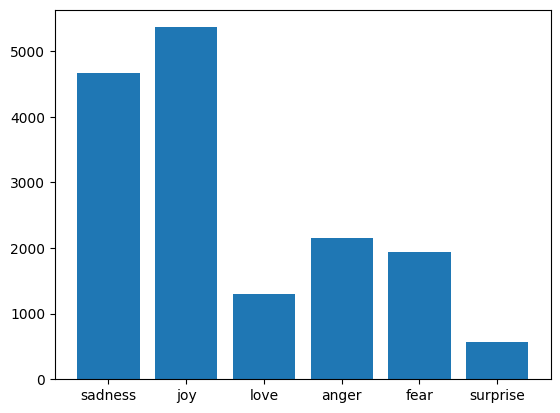

In [22]:
label_count = Counter(train_data["label"])
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

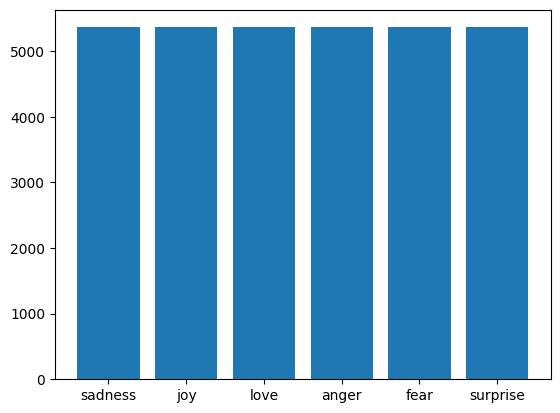

In [23]:
label_count = Counter(train_data_oversample)
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

In [24]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)

In [25]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: list, labels: list, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data, labels):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

In [26]:
train_instances = preprocess(lemmatized_train_data, train_data["label"], tokenizer)
val_instances = preprocess(lemmatized_val_data, validation_data["label"], tokenizer)
test_instances = preprocess(lemmatized_test_data, test_data["label"], tokenizer)

In [27]:
len(train_instances)

16000

In [28]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [29]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(50, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(x)

        return y
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        for epoch in range(epochs):
            train_batches = batching(
                train_instances,
                batch_size=batch_size,
                shuffle=True)
            
            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_f1 = self.evaluate2(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate2(val_instances, batch_size=batch_size)

            print(f"Epoch {epoch + 1} train F1 score: {train_f1}, validation F1 score: {val_f1}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")
    
    def evaluate2(self, instances, batch_size):
        """ 
        To make evaluations against the gold standard (true labels) from the 
        data.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        true = []
        pred = []

        for inputs, labels in batches:
            true.extend(labels)
            pred.extend(self.predict(inputs))

        return f1_score(true, pred, average="macro")

In [30]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=50, batch_size=16)

100%|██████████| 1000/1000 [00:04<00:00, 245.29it/s]


Epoch 1 train F1 score: 0.8169364712022453, validation F1 score: 0.7363771927121089


100%|██████████| 1000/1000 [00:03<00:00, 259.04it/s]


Epoch 2 train F1 score: 0.9319277969432789, validation F1 score: 0.8519428126500328


100%|██████████| 1000/1000 [00:03<00:00, 257.26it/s]


Epoch 3 train F1 score: 0.9471526543215597, validation F1 score: 0.8434592239869322


100%|██████████| 1000/1000 [00:03<00:00, 256.61it/s]


Epoch 4 train F1 score: 0.9772918514896869, validation F1 score: 0.852887087429468


100%|██████████| 1000/1000 [00:03<00:00, 255.36it/s]


Epoch 5 train F1 score: 0.984851607859654, validation F1 score: 0.8573314703802506


100%|██████████| 1000/1000 [00:03<00:00, 250.36it/s]


Epoch 6 train F1 score: 0.9795852668330127, validation F1 score: 0.8624119691801302


100%|██████████| 1000/1000 [00:03<00:00, 259.89it/s]


Epoch 7 train F1 score: 0.9841404380447155, validation F1 score: 0.8391796060447324


100%|██████████| 1000/1000 [00:03<00:00, 261.17it/s]


Epoch 8 train F1 score: 0.991160164607671, validation F1 score: 0.8595112158771423


100%|██████████| 1000/1000 [00:03<00:00, 271.21it/s]


Epoch 9 train F1 score: 0.9883616446854697, validation F1 score: 0.8461010902212323


100%|██████████| 1000/1000 [00:03<00:00, 267.42it/s]


Epoch 10 train F1 score: 0.9950838265763751, validation F1 score: 0.855065202562554


100%|██████████| 1000/1000 [00:03<00:00, 266.15it/s]


Epoch 11 train F1 score: 0.9935490465348931, validation F1 score: 0.8553609501028571


100%|██████████| 1000/1000 [00:03<00:00, 266.98it/s]


Epoch 12 train F1 score: 0.9917539921087993, validation F1 score: 0.8542253056154238


100%|██████████| 1000/1000 [00:03<00:00, 255.02it/s]


Epoch 13 train F1 score: 0.992754472210143, validation F1 score: 0.8384616463696323


100%|██████████| 1000/1000 [00:03<00:00, 252.53it/s]


Epoch 14 train F1 score: 0.993600246534243, validation F1 score: 0.8300157729112527


100%|██████████| 1000/1000 [00:03<00:00, 251.13it/s]


Epoch 15 train F1 score: 0.9937872076350427, validation F1 score: 0.8457323169963112


100%|██████████| 1000/1000 [00:04<00:00, 249.35it/s]


Epoch 16 train F1 score: 0.9918241976807872, validation F1 score: 0.8299736464095114


100%|██████████| 1000/1000 [00:03<00:00, 256.86it/s]


Epoch 17 train F1 score: 0.9946442632212031, validation F1 score: 0.8538637347012736


100%|██████████| 1000/1000 [00:03<00:00, 253.33it/s]


Epoch 18 train F1 score: 0.9950581161239346, validation F1 score: 0.8504649577494169


100%|██████████| 1000/1000 [00:03<00:00, 255.11it/s]


Epoch 19 train F1 score: 0.994279046307978, validation F1 score: 0.8422672964856875


100%|██████████| 1000/1000 [00:03<00:00, 259.33it/s]


Epoch 20 train F1 score: 0.9952532992098052, validation F1 score: 0.8393021223006293


100%|██████████| 1000/1000 [00:03<00:00, 263.26it/s]


Epoch 21 train F1 score: 0.9953724408020258, validation F1 score: 0.8310738559086949


100%|██████████| 1000/1000 [00:03<00:00, 263.40it/s]


Epoch 22 train F1 score: 0.9942201452681964, validation F1 score: 0.8495047834107364


100%|██████████| 1000/1000 [00:03<00:00, 258.90it/s]


Epoch 23 train F1 score: 0.9953953621691584, validation F1 score: 0.8337498798284676


100%|██████████| 1000/1000 [00:03<00:00, 260.09it/s]


Epoch 24 train F1 score: 0.994385142927506, validation F1 score: 0.8340798109178501


100%|██████████| 1000/1000 [00:03<00:00, 259.90it/s]


Epoch 25 train F1 score: 0.9949333982858545, validation F1 score: 0.8410400628368419


100%|██████████| 1000/1000 [00:03<00:00, 261.85it/s]


Epoch 26 train F1 score: 0.990091463396189, validation F1 score: 0.8286096419323709


100%|██████████| 1000/1000 [00:03<00:00, 255.27it/s]


Epoch 27 train F1 score: 0.9924164278656799, validation F1 score: 0.8383880032383298


100%|██████████| 1000/1000 [00:03<00:00, 258.63it/s]


Epoch 28 train F1 score: 0.9956702019008031, validation F1 score: 0.8450866704185165


100%|██████████| 1000/1000 [00:03<00:00, 253.33it/s]


Epoch 29 train F1 score: 0.9963271991170619, validation F1 score: 0.8438278171674947


100%|██████████| 1000/1000 [00:03<00:00, 255.49it/s]


Epoch 30 train F1 score: 0.9953245136908547, validation F1 score: 0.8500207094062499


100%|██████████| 1000/1000 [00:03<00:00, 259.21it/s]


Epoch 31 train F1 score: 0.9953138414799826, validation F1 score: 0.837133389656154


100%|██████████| 1000/1000 [00:03<00:00, 262.01it/s]


Epoch 32 train F1 score: 0.9930582184825932, validation F1 score: 0.8257885020447292


100%|██████████| 1000/1000 [00:03<00:00, 268.40it/s]


Epoch 33 train F1 score: 0.9949654192706189, validation F1 score: 0.8387710059991406


100%|██████████| 1000/1000 [00:03<00:00, 256.92it/s]


Epoch 34 train F1 score: 0.9957705592158229, validation F1 score: 0.8347525230480524


100%|██████████| 1000/1000 [00:03<00:00, 264.19it/s]


Epoch 35 train F1 score: 0.9961952115943631, validation F1 score: 0.8415970127124722


100%|██████████| 1000/1000 [00:03<00:00, 261.65it/s]


Epoch 36 train F1 score: 0.9932472590349265, validation F1 score: 0.8221922907764151


100%|██████████| 1000/1000 [00:03<00:00, 262.36it/s]


Epoch 37 train F1 score: 0.9938668651141147, validation F1 score: 0.8315152035303388


100%|██████████| 1000/1000 [00:03<00:00, 260.37it/s]


Epoch 38 train F1 score: 0.9957164531900456, validation F1 score: 0.8385874415766121


100%|██████████| 1000/1000 [00:03<00:00, 261.21it/s]


Epoch 39 train F1 score: 0.9952174703819652, validation F1 score: 0.8425651683788217


100%|██████████| 1000/1000 [00:03<00:00, 262.83it/s]


Epoch 40 train F1 score: 0.9951684314440744, validation F1 score: 0.8458335034015189


100%|██████████| 1000/1000 [00:03<00:00, 252.42it/s]


Epoch 41 train F1 score: 0.9954442086461883, validation F1 score: 0.8460447732880403


100%|██████████| 1000/1000 [00:03<00:00, 257.19it/s]


Epoch 42 train F1 score: 0.9955194136931684, validation F1 score: 0.8377554108120674


100%|██████████| 1000/1000 [00:03<00:00, 260.16it/s]


Epoch 43 train F1 score: 0.9959010794373931, validation F1 score: 0.8296393013353486


100%|██████████| 1000/1000 [00:03<00:00, 261.36it/s]


Epoch 44 train F1 score: 0.9962238876557273, validation F1 score: 0.8240043676909966


100%|██████████| 1000/1000 [00:03<00:00, 267.02it/s]


Epoch 45 train F1 score: 0.9954694695906802, validation F1 score: 0.8352895640687922


100%|██████████| 1000/1000 [00:03<00:00, 262.82it/s]


Epoch 46 train F1 score: 0.9919611832870091, validation F1 score: 0.8143008043616645


100%|██████████| 1000/1000 [00:03<00:00, 261.50it/s]


Epoch 47 train F1 score: 0.9951685993284567, validation F1 score: 0.83525287101219


100%|██████████| 1000/1000 [00:03<00:00, 260.32it/s]


Epoch 48 train F1 score: 0.9962834547049183, validation F1 score: 0.8450210321020307


100%|██████████| 1000/1000 [00:03<00:00, 254.50it/s]


Epoch 49 train F1 score: 0.9963510402121645, validation F1 score: 0.8342009879556141


100%|██████████| 1000/1000 [00:03<00:00, 262.67it/s]


Epoch 50 train F1 score: 0.9959506713998932, validation F1 score: 0.8391980724518494


In [31]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.8775
Precision: 0.8229812774420534
Recall: 0.8240593140872144
F1 Score: 0.823113813490609
Confusion Matrix:
[[540  10   4  18   9   0]
 [  9 620  42  16   2   6]
 [  9  26 115   6   2   1]
 [ 15   8   1 245   4   2]
 [ 10   0   0  12 192  10]
 [  5   5   1   0  12  43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       581
           1       0.93      0.89      0.91       695
           2       0.71      0.72      0.71       159
           3       0.82      0.89      0.86       275
           4       0.87      0.86      0.86       224
           5       0.69      0.65      0.67        66

    accuracy                           0.88      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.88      0.88      0.88      2000

